## Homework 7    
### Due Friday, 11/13/2024
### CO2 Data
In class, we saw a series of daily CO2 measurements from Mauna Loa.  The origional data can be found on NOAA's website here:

https://gml.noaa.gov/ccgg/trends/data.html

This is an important data set for monitoring the increase in CO2 over time, because it is a long and (mostly) complete series of observations.

However, this data has a seasonal variation - it goes up and down depending on the time of year, on top of the long-term trend.  Plus of course there's variation from day to day.

What we'd like to do it get rid of the noise and the yearly cycle, and find the long-term trend.  There are lots of possible ways to do this, and none of them are necessarially the best.  This assignment is going to be more open-ended than most.  Your goal is to find a good model for the long-term CO2 trend, and make some prediction about what the concentraion of CO2 will be in the future.

The exercises below should be a guide through a mix of smoothing, fitlering and fitting, but how you want to get to the goals is mostly up to you.

### Question a

a) From what we saw in class (on Oct. 30th) you should be able to load the daily data and match it to a day since the data began (y_n and t_n in Dr. Morsony's notebook).  You can also make an array of all the days covered by the data (t_all) and an array with the measurement for each data you have data (y_all), but there will be days without data.

Deciding what to do with the missing data has a big impact on how we interperate our data, particularly if we want to use a Fourier transforms.

In class, we tried filling in the missing data with zero, with the overall average, and with interpolated values.  None of these worked particularly well, though interpolation did a bit better.

One thing you could try is doing some smoothing of the data first, then interpolating to fill in the missing values.  This might help get rid of some of the daily noise.

Give that a try.  Try smoothing somehow, maybe averaging over 7 days or 30 days?, then interpolate on the smoothed data to fill in the missing data.  Then try a Fourier transfor and see what the power spectrum looks like.  Is it any cleaner?

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq
from scipy.interpolate import interp1d
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

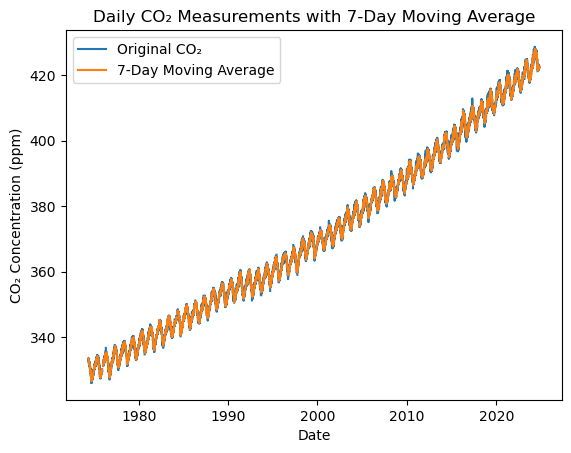

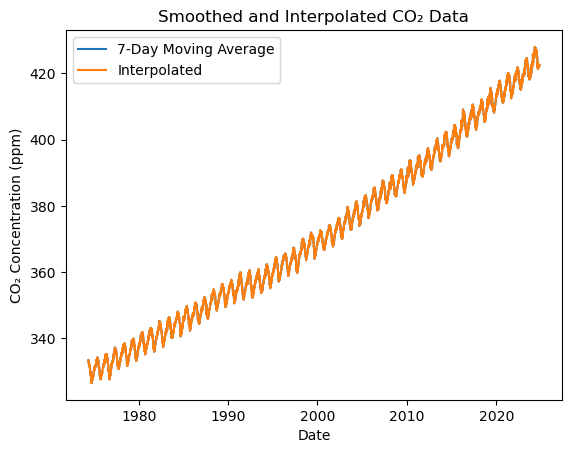

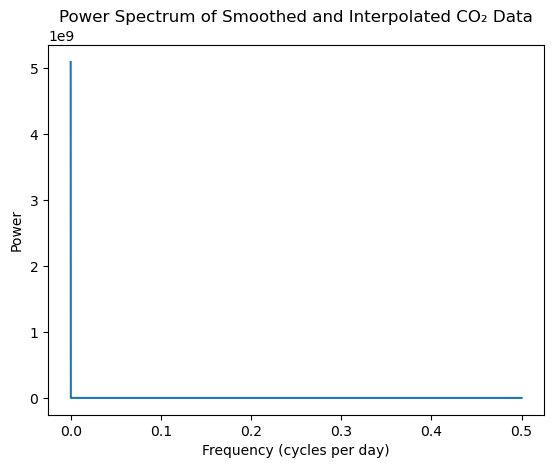

In [56]:
# 1. Load Mauna Loa CO₂ Daily Data
co2_daily = np.loadtxt("co2_daily_mlo.txt")

# Extract relevant columns: Year, Month, Day, Decimal Date, CO2
date_year = co2_daily[:, 0].astype(int)
date_month = co2_daily[:, 1].astype(int)
date_day = co2_daily[:, 2].astype(int)
date_decimal = co2_daily[:, 3]
co2 = co2_daily[:, 4]

# Convert dates to datetime objects
dates = [datetime(year, month, day) for year, month, day in zip(date_year, date_month, date_day)]

# Calculate days since the start of the dataset
start_date = dates[0]
end_date = dates[-1]
total_days = (end_date - start_date).days + 1

# Create a list of all dates in the range
all_dates = [start_date + timedelta(days=i) for i in range(total_days)]

# Initialize CO₂ array with NaNs for missing days
y_all = np.full(total_days, np.nan)

# Map each date to its corresponding index in the complete array
date_to_index = {date: idx for idx, date in enumerate(all_dates)}

# Populate the CO₂ measurements
for date, value in zip(dates, co2):
    idx = date_to_index[date]
    y_all[idx] = value

# 2. Smooth the Data Using a Moving Average
def moving_average(data, window_size):
    smoothed = np.empty(len(data))
    smoothed[:] = np.nan
    
    half_window = window_size // 2
    
    for i in range(len(data)):
        # Define the window range
        start = max(i - half_window, 0)
        end = min(i + half_window + 1, len(data))
        
        window = data[start:end]
        valid = window[~np.isnan(window)]
        
        if len(valid) > 0:
            smoothed[i] = np.mean(valid)
        else:
            smoothed[i] = np.nan
    
    return smoothed

# Apply a 7-day moving average to smooth the data
window_size = 7
co2_smoothed = moving_average(y_all, window_size)

# 3. Plot Original and Smoothed CO₂ Data
plt.plot(all_dates, y_all, label='Original CO₂')
plt.plot(all_dates, co2_smoothed, label='7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('CO₂ Concentration (ppm)')
plt.title('Daily CO₂ Measurements with 7-Day Moving Average')
plt.legend()
plt.show()

# 4. Interpolate Missing Values After Smoothing
# Identify indices with valid (non-NaN) smoothed data
valid_indices = ~np.isnan(co2_smoothed)

# Create an array of indices corresponding to each day
x = np.arange(total_days)

# Perform linear interpolation on the smoothed data
interp_func = interp1d(x[valid_indices], co2_smoothed[valid_indices], kind='linear', fill_value="extrapolate")
co2_interpolated = interp_func(x)

# 5. Plot Smoothed and Interpolated CO₂ Data
plt.plot(all_dates, co2_smoothed, label='7-Day Moving Average')
plt.plot(all_dates, co2_interpolated, label='Interpolated')
plt.xlabel('Date')
plt.ylabel('CO₂ Concentration (ppm)')
plt.title('Smoothed and Interpolated CO₂ Data')
plt.legend()
plt.show()

# 6. Perform Fourier Transform on Interpolated Data
# Number of samples
N = len(co2_interpolated)

# Sampling interval: 1 day
T = 1.0

# Perform Fast Fourier Transform (FFT) using NumPy
yf = fft(co2_interpolated)
xf = fftfreq(N, T)[:N//2]  # Only positive frequencies

# Compute the power spectrum
power_spectrum = (2.0 / N) * np.abs(yf[:N//2])**2

# 7. Plot the Power Spectrum
plt.plot(xf, power_spectrum)
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Power')
plt.title('Power Spectrum of Smoothed and Interpolated CO₂ Data')
plt.show()

### Question b

b) Once you have a decent looking data series, try filtering out low frequencies (less than a couple of years?) and do an inverse Fourier transform, and see what it looks like.  Is the behavior at the end any better?

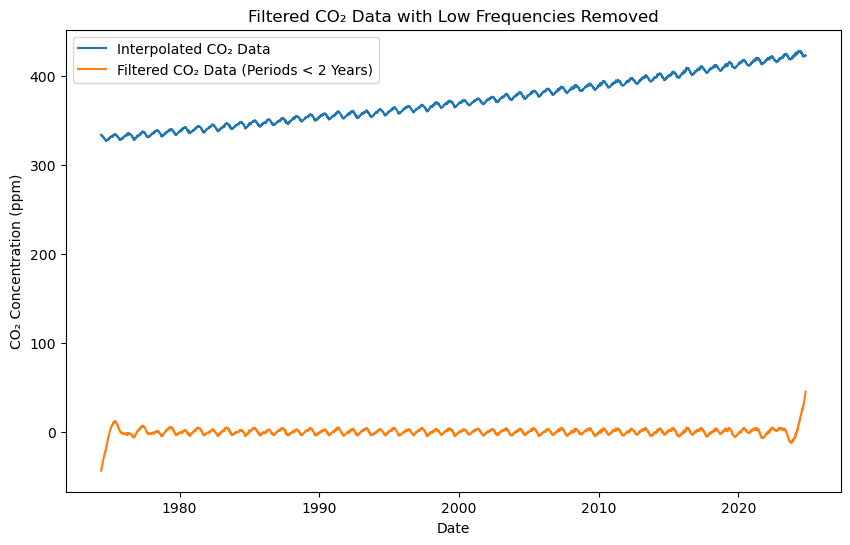

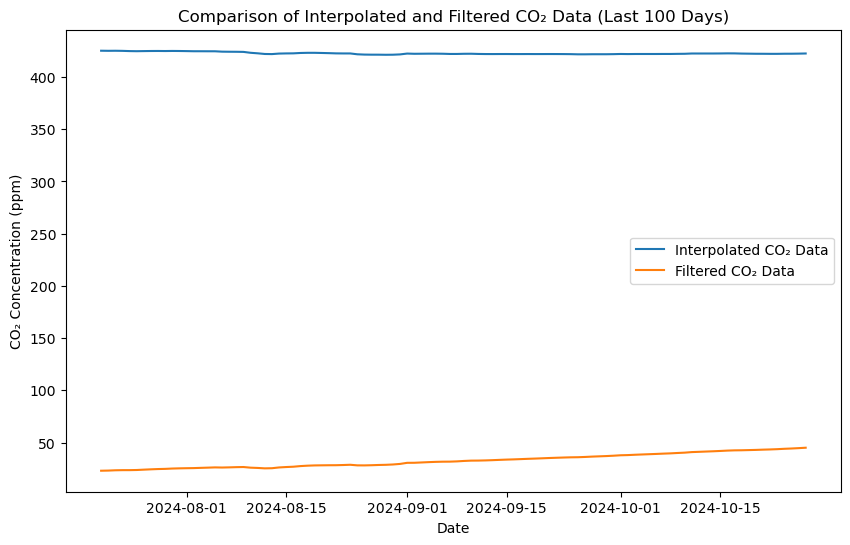

In [62]:
# 1. Define the Frequency Threshold
# Define the minimum period to filter out (in days)
min_period_days = 365 * 2

# Calculate the corresponding frequency threshold (cycles per day)
f_threshold = 1 / min_period_days

# 2. Identify Frequencies to Filter Out
# Create a mask for frequencies greater than or equal to the threshold
mask = xf >= f_threshold

if N % 2 == 0:
    # For even N, include the Nyquist frequency
    yf_positive = yf[:N//2 + 1]
    mask_extended = mask.copy()
    
    # If N is even, ensure mask has the same length as yf_positive
    # Since xf has length N//2, append True for the Nyquist frequency
    mask_extended = np.append(mask_extended, True)
    
    yf_filtered_positive = yf_positive * mask_extended
    
    # Initialize a full FFT array with zeros
    yf_full_filtered = np.zeros(N, dtype=complex)
    
    # Assign the filtered positive frequencies
    yf_full_filtered[:N//2 + 1] = yf_filtered_positive
    
    # Assign the negative frequencies as the complex conjugate of the positive frequencies
    yf_full_filtered[N//2 + 1:] = np.conj(yf_filtered_positive[1:N//2][::-1])
else:
    # For odd N, there's no unique Nyquist frequency
    yf_positive = yf[:N//2 + 1]  # Include the middle frequency
    mask_extended = mask.copy()
    
    # Since N is odd, yf_positive has one more element than mask
    # Append True for the middle frequency to match lengths
    mask_extended = np.append(mask_extended, True)
    
    yf_filtered_positive = yf_positive * mask_extended
    
    # Initialize a full FFT array with zeros
    yf_full_filtered = np.zeros(N, dtype=complex)
    
    # Assign the filtered positive frequencies
    yf_full_filtered[:N//2 + 1] = yf_filtered_positive
    
    # Assign the negative frequencies as the complex conjugate of the positive frequencies
    yf_full_filtered[N//2 + 1:] = np.conj(yf_filtered_positive[1:N//2 +1][::-1])

# 3. Perform Inverse Fourier Transform
# Convert the filtered frequency data back to the time domain
y_filtered = np.fft.ifft(yf_full_filtered).real

# 4. Plot the Filtered CO₂ Data
plt.figure(figsize=(10, 6))
plt.plot(all_dates, co2_interpolated, label='Interpolated CO₂ Data')
plt.plot(all_dates, y_filtered, label='Filtered CO₂ Data (Periods < 2 Years)')
plt.xlabel('Date')
plt.ylabel('CO₂ Concentration (ppm)')
plt.title('Filtered CO₂ Data with Low Frequencies Removed')
plt.legend()
plt.show()

# 5. Assess Improvement at the End of the Dataset
# Define the range to inspect (e.g., the last 100 days)
inspect_days = 100
inspect_start = N - inspect_days
inspect_end = N

# Plot the last 100 days of both interpolated and filtered data
plt.figure(figsize=(10, 6))
plt.plot(all_dates[inspect_start:inspect_end], co2_interpolated[inspect_start:inspect_end], label='Interpolated CO₂ Data')
plt.plot(all_dates[inspect_start:inspect_end], y_filtered[inspect_start:inspect_end], label='Filtered CO₂ Data')
plt.xlabel('Date')
plt.ylabel('CO₂ Concentration (ppm)')
plt.title(f'Comparison of Interpolated and Filtered CO₂ Data (Last {inspect_days} Days)')
plt.legend()
plt.show()

### Question c

c) Another approach is to try to smooth out the annual (and daily) variations, rather than filter them out.  Since we're assuming our data varied on a year timescale, try smoothing on a timescale of a year or more.  Maybe a 365-day moving average?  (Remember not to include the missing data in your smoothing.) Find a good smoothing and plot your smoothed data.  How does it compare to the filtered data from part b)?


You can also reduce the number of data points, maybe take monthly or yearly averages rather than trying to fill in data at every point.

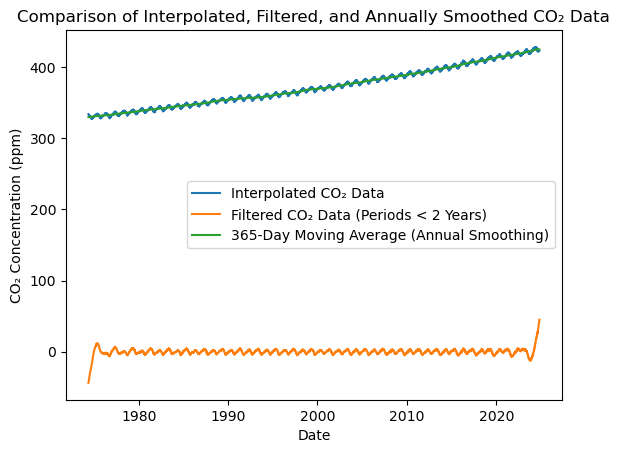

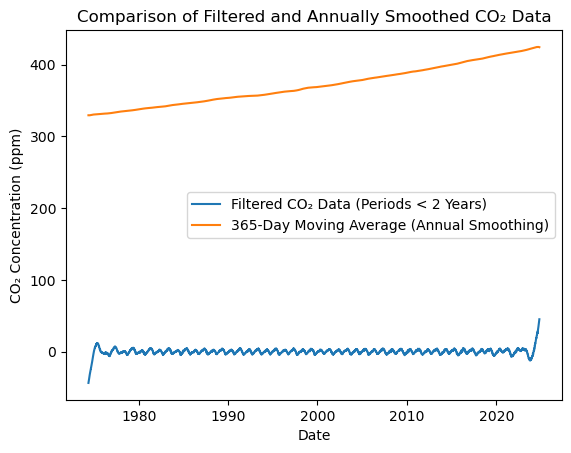

In [52]:
# 1. Define a 365-Day Moving Average Function
def moving_average_annual(data, window_size):
    smoothed = np.empty(len(data))
    smoothed[:] = np.nan
    
    half_window = window_size // 2
    
    for i in range(len(data)):
        # Define the window range
        start = max(i - half_window, 0)
        end = min(i + half_window + 1, len(data))
        
        window = data[start:end]
        valid = window[~np.isnan(window)]
        
        if len(valid) > 0:
            smoothed[i] = np.mean(valid)
        else:
            smoothed[i] = np.nan
    
    return smoothed

# 2. Apply a 365-Day Moving Average to Smooth the Data
annual_window_size = 365
co2_smoothed_annual = moving_average_annual(co2_interpolated, annual_window_size)

# 3. Plot the Annually Smoothed CO₂ Data
plt.plot(all_dates, co2_interpolated, label='Interpolated CO₂ Data')
plt.plot(all_dates, y_filtered, label='Filtered CO₂ Data (Periods < 2 Years)')
plt.plot(all_dates, co2_smoothed_annual, label='365-Day Moving Average (Annual Smoothing)')
plt.xlabel('Date')
plt.ylabel('CO₂ Concentration (ppm)')
plt.title('Comparison of Interpolated, Filtered, and Annually Smoothed CO₂ Data')
plt.legend()
plt.show()

# 4. Additional Comparison Plot Between Filtered and Smoothed Data
plt.plot(all_dates, y_filtered, label='Filtered CO₂ Data (Periods < 2 Years)')
plt.plot(all_dates, co2_smoothed_annual, label='365-Day Moving Average (Annual Smoothing)')
plt.xlabel('Date')
plt.ylabel('CO₂ Concentration (ppm)')
plt.title('Comparison of Filtered and Annually Smoothed CO₂ Data')
plt.legend()
plt.show()

### Question d

d) Last, we want to use the long-term trend to make some predictions for the future.  Fourier transformes of interpolation are probably going to be a bad way to do this, because they tend to vary a lot at the ends, or depend more heavily on the data near the end.  That's bad if you're trying to go beyond the end.

Instead, you'll probably need to do some sort of fitting.  You might try fitting a polynomial or exponential plus polynomial, or some other function.  Try fitting to the raw data, and some good smoothed or filtered data.  If you're fitting data you've filtered, you might even want to cut off the ends.  Pick what fit you think is "best".

Then use your fit to make some predictions.  What will the CO2 concentration be in 2025? in 2030? 2050? 2100?  How good do you think your predictions are?  Can you quantify that (maybe not)?  Do your predictions start behaving oddly at some point) (e.g., do they start to decrease?)

Linear Fit Parameters: a = 1.8501 ppm/year, b = -3327.72 ppm
Exponential Fit Parameters: a = 0.0000, b = 0.015491, c = 251.02
Linear Fit Predictions:
2025: 418.65 ppm
2030: 427.90 ppm
2050: 464.90 ppm
2100: 557.40 ppm

Exponential Fit Predictions:
2025: 425.34 ppm
2030: 439.38 ppm
2050: 507.79 ppm
2100: 808.09 ppm


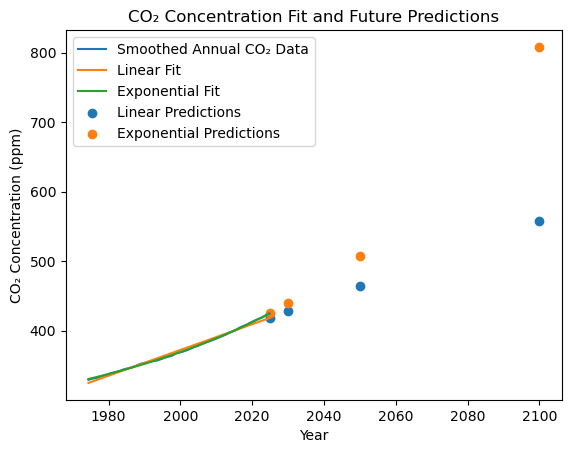

Linear Fit R-squared: 0.9896
Exponential Fit R-squared: 0.9994


In [64]:
# 1. Convert Dates to Numeric Values (Decimal Years)
def decimal_year(dates):
    return np.array([date.year + (date.timetuple().tm_yday - 1)/365.25 for date in dates])
years = decimal_year(all_dates)

# 2. Define Fitting Functions
# Linear function: CO2 = a * Year + b
def linear_func(x, a, b):
    return a * x + b

# Exponential function: CO2 = a * exp(b * Year) + c
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

# 3. Fit a Linear Function to the Smoothed Data
# Remove NaN values if any
valid_indices = ~np.isnan(co2_smoothed_annual)
years_valid = years[valid_indices]
co2_valid = co2_smoothed_annual[valid_indices]

# Perform linear fit
params_linear, covariance_linear = curve_fit(linear_func, years_valid, co2_valid)

# Extract parameters
a_linear, b_linear = params_linear
print(f"Linear Fit Parameters: a = {a_linear:.4f} ppm/year, b = {b_linear:.2f} ppm")

# 4. Fit an Exponential Function to the Smoothed Data
# Define initial guesses for a, b, c
initial_guess = [1, 0.01, 300]
try:
    params_exponential, covariance_exponential = curve_fit(
        exponential_func, 
        years_valid, 
        co2_valid, 
        p0=initial_guess, 
        maxfev=10000
    )
    a_exp, b_exp, c_exp = params_exponential
    print(f"Exponential Fit Parameters: a = {a_exp:.4f}, b = {b_exp:.6f}, c = {c_exp:.2f}")
except RuntimeError as e:
    print("Exponential fit did not converge:", e)
    params_exponential = None

# 5. Make Predictions for Future Years
# Define prediction years
future_years = np.array([2025, 2030, 2050, 2100])

# Convert to decimal years
future_dates = [datetime(year, 1, 1) for year in future_years]
future_years_decimal = decimal_year(future_dates)

# Make predictions using linear fit
co2_pred_linear = linear_func(future_years_decimal, a_linear, b_linear)

print("Linear Fit Predictions:")
for year, co2_val in zip(future_years, co2_pred_linear):
    print(f"{year}: {co2_val:.2f} ppm")

# Make predictions using exponential fit if successful
if params_exponential is not None:
    co2_pred_exponential = exponential_func(future_years_decimal, a_exp, b_exp, c_exp)
    
    print("\nExponential Fit Predictions:")
    for year, co2_val in zip(future_years, co2_pred_exponential):
        print(f"{year}: {co2_val:.2f} ppm")

# 6. Plot the Fit and Predictions
plt.plot(years_valid, co2_valid, label='Smoothed Annual CO₂ Data')
plt.plot(years_valid, linear_func(years_valid, *params_linear), label='Linear Fit')

if params_exponential is not None:
    plt.plot(years_valid, exponential_func(years_valid, *params_exponential), label='Exponential Fit')

# Plot predictions
plt.scatter(future_years_decimal, co2_pred_linear, label='Linear Predictions')
if params_exponential is not None:
    plt.scatter(future_years_decimal, co2_pred_exponential, label='Exponential Predictions')

plt.xlabel('Year')
plt.ylabel('CO₂ Concentration (ppm)')
plt.title('CO₂ Concentration Fit and Future Predictions')
plt.legend()
plt.show()

# 7. Assess the Fit's Quality (R-squared)
# Linear Fit R-squared
co2_pred_linear_fit = linear_func(years_valid, a_linear, b_linear)
r2_linear = r2_score(co2_valid, co2_pred_linear_fit)
print(f"Linear Fit R-squared: {r2_linear:.4f}")

if params_exponential is not None:
    # Exponential Fit R-squared
    co2_pred_exponential_fit = exponential_func(years_valid, a_exp, b_exp, c_exp)
    r2_exponential = r2_score(co2_valid, co2_pred_exponential_fit)
    print(f"Exponential Fit R-squared: {r2_exponential:.4f}")